#Brain MRI Scan Classification Using SVM

This project focuses on the binary classification of brain MRI scans to predict the presence or absence of tumors. Employing a Support Vector Machine (SVM) classifier and Principal Component Analysis (PCA) for feature extraction, the workflow encompasses data preparation, model training, evaluation, and the creation of a graphical user interface (GUI) for real-time tumor prediction.

#SVM in Python



---



##Import Required Libraries

In [1]:
import os
import cv2
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score
import joblib

##Dataset Distribution

Class: no_tumor
  Training Images: 394
  Testing Images: 104

Class: pituitary_tumor
  Training Images: 641
  Testing Images: 73



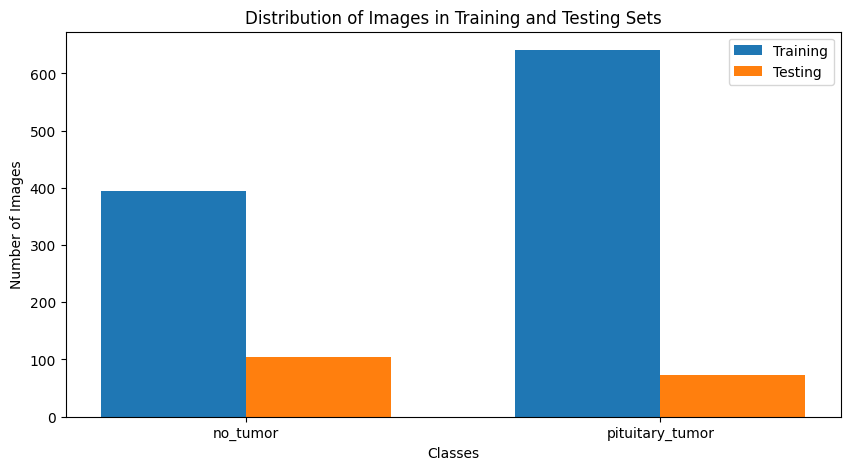

In [15]:
def dataset_distribution(path, classes):
    train_counts = []
    test_counts = []

    for cls in classes:
        train_path = os.path.join(path, 'Training', cls)
        test_path = os.path.join(path, 'Testing', cls)

        train_count = len(os.listdir(train_path))
        test_count = len(os.listdir(test_path))

        train_counts.append(train_count)
        test_counts.append(test_count)

        print(f"Class: {cls}")
        print(f"  Training Images: {train_count}")
        print(f"  Testing Images: {test_count}")
        print()

    # Visualize the distribution
    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    index = np.arange(len(classes))
    plt.bar(index, train_counts, bar_width, label='Training')
    plt.bar(index + bar_width, test_counts, bar_width, label='Testing')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images in Training and Testing Sets')
    plt.xticks(index + bar_width / 2, classes)
    plt.legend()
    plt.show()

dataset_distribution('brain_tumor', ['no_tumor', 'pituitary_tumor'])

The dataset is imbalanced, we will deal with this encounter by doubling the weight of the tumor class images.

##Prepare Training Data

In [34]:
path = os.listdir('brain_tumor/Training/')
classes = {'no_tumor': 0, 'pituitary_tumor': 1}

X = []
Y = []

for cls in classes:
    pth = 'brain_tumor/Training/' + cls
    for j in os.listdir(pth):
        img = cv2.imread(pth + '/' + j, 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])

##Reshape and Split Data

In [35]:
# Reshape data
X = np.array(X)
Y = np.array(Y)
X_updated = X.reshape(len(X), -1)
# Split Data
xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10, test_size=0.20)

##Feature Selection and Scaling

In [36]:
# Feature Scaling
xtrain = xtrain / 255
xtest = xtest / 255

# Feature Selection: PCA
pca = PCA(0.98)
xtrain_pca = pca.fit_transform(xtrain)  # Apply PCA transformation during training
xtest_pca = pca.transform(xtest)        # Apply the same transformation during testing
joblib.dump(pca, 'pca_model.joblib')

['pca_model.joblib']

##Train and Save Model

In [37]:
sv = SVC()
sv.fit(xtrain_pca, ytrain)  # Train the model using the PCA-transformed training data
# Save the trained model using joblib
joblib.dump(sv, 'svm_model.joblib')

['svm_model.joblib']

##Model Evaluation

###Train and Test Score

In [38]:
# Evaluation

print("Training Score (SVM):", sv.score(xtrain_pca, ytrain))
print("Testing Score (SVM):", sv.score(xtest_pca, ytest))

# Missclassified
pred = sv.predict(xtest_pca)
misclassified = np.where(ytest != pred)
print("Total Misclassified Samples(SVM): ", len(misclassified[0]))

Training Score (SVM): 0.9975845410628019
Testing Score (SVM): 0.9516908212560387
Total Misclassified Samples(SVM):  10


###ROC Curve

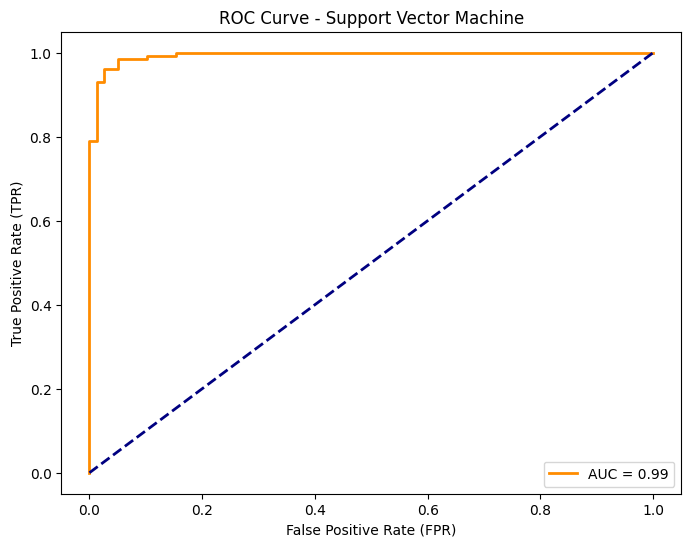

In [39]:
pred_prob = sv.decision_function(xtest_pca)  # Decision function scores for binary classification
fpr, tpr, thresholds = roc_curve(ytest, pred_prob)
roc_auc = roc_auc_score(ytest, pred_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Support Vector Machine')
plt.legend(loc='lower right')
plt.show()

##Visaulize Model Predictions on Testing Data

###Define Labels

In [40]:
dec = {0: 'No Tumor', 1: 'Positive Tumor'}

###No Tumor Images

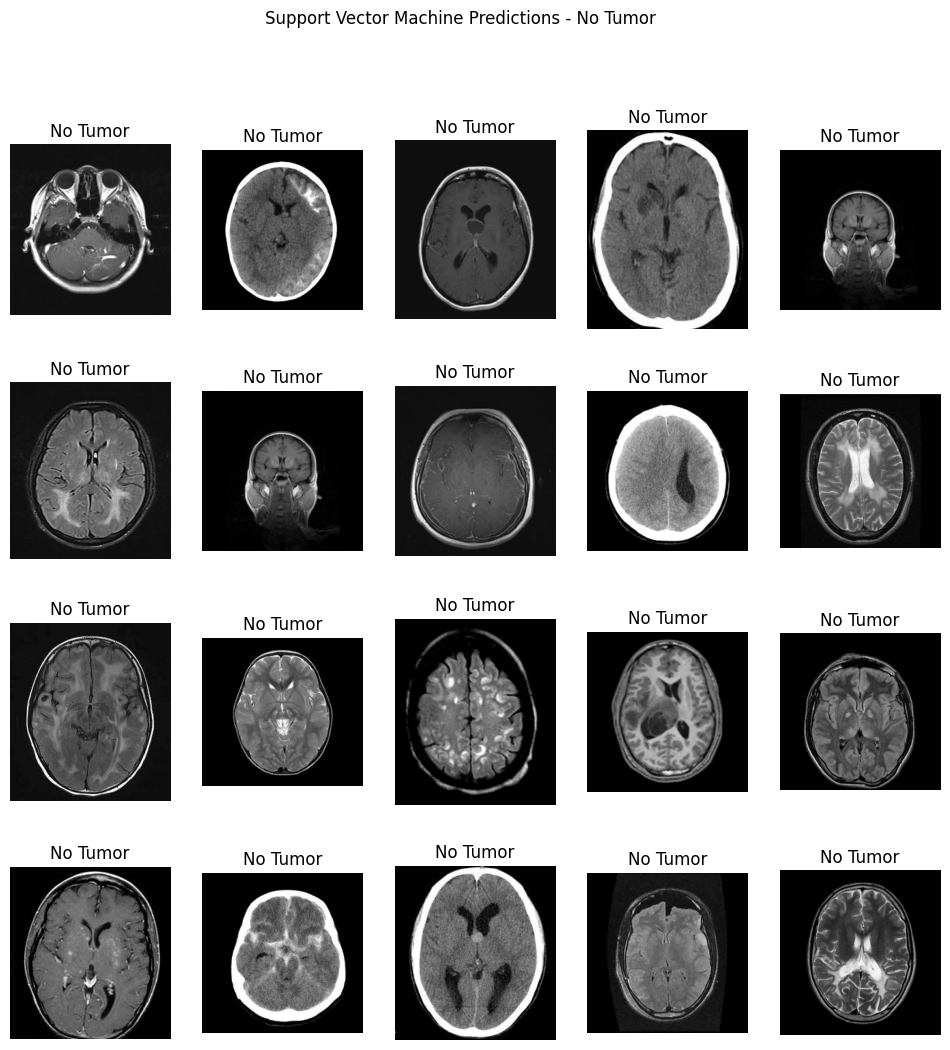

In [41]:
# Visualize SVM predictions on 'no_tumor' images
plt.figure(figsize=(12, 12))
plt.suptitle('Support Vector Machine Predictions - No Tumor')

# Testing SVM on 'no_tumor'
for c, i in enumerate(os.listdir('brain_tumor/Testing/no_tumor/')[:20], 1):
    plt.subplot(4, 5, c)  # Use 4 rows and 5 columns for a 20-image display
    img = cv2.imread('brain_tumor/Testing/no_tumor/' + i, 0)
    img1 = cv2.resize(img, (200, 200))
    img1 = img1.reshape(1, -1) / 255
    img1_pca = pca.transform(img1)  # Apply PCA transformation to the testing image
    prediction = sv.predict(img1_pca)
    plt.imshow(img, cmap='gray')
    plt.title(f"{dec[prediction[0]]}")
    plt.axis('off')

plt.show()

###Pituiary Tumor Images

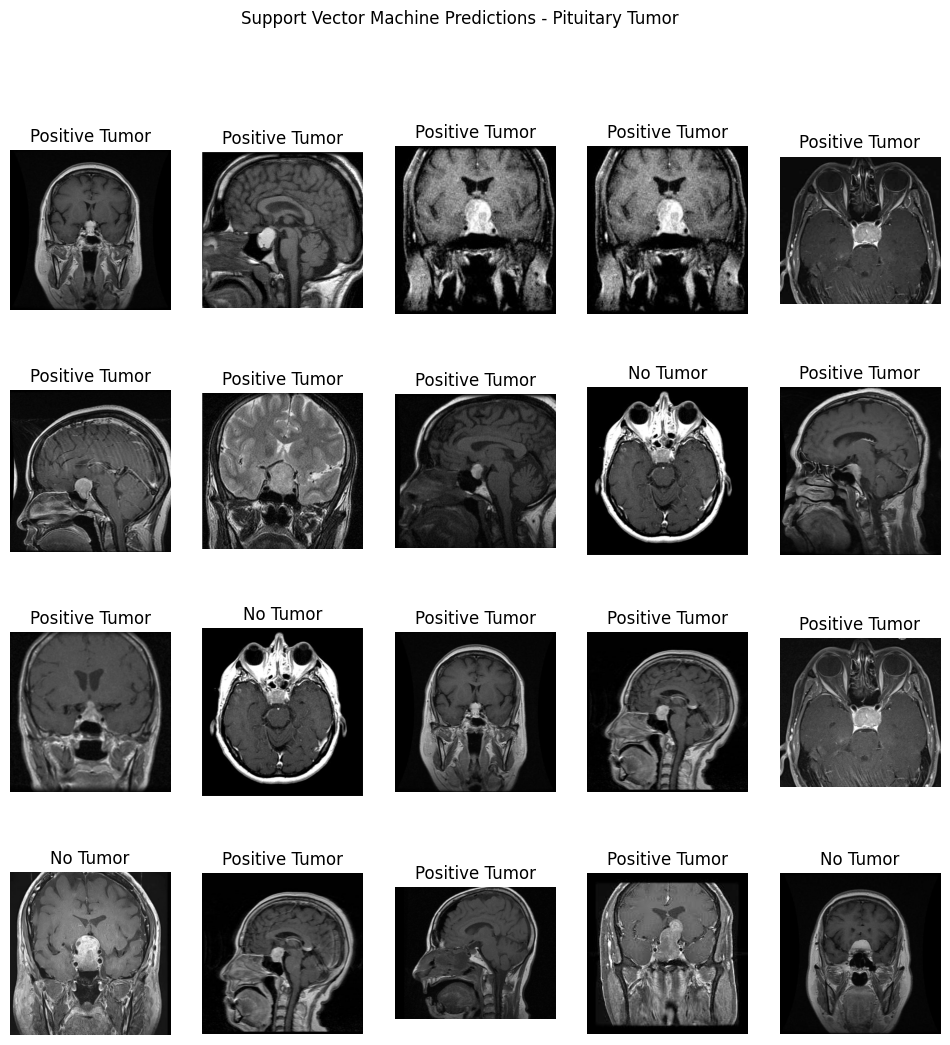

In [42]:
# Visualize SVM predictions on 'pituitary_tumor' images
plt.figure(figsize=(12, 12))
plt.suptitle('Support Vector Machine Predictions - Pituitary Tumor')

# Testing SVM on 'pituitary_tumor'
for c, i in enumerate(os.listdir('brain_tumor/Testing/pituitary_tumor/')[:20], 1):
    plt.subplot(4, 5, c)  # Use 4 rows and 5 columns for a 20-image display
    img = cv2.imread('brain_tumor/Testing/pituitary_tumor/' + i, 0)
    img1 = cv2.resize(img, (200, 200))
    img1 = img1.reshape(1, -1) / 255
    img1_pca = pca.transform(img1)  # Apply PCA transformation to the testing image
    prediction = sv.predict(img1_pca)
    plt.imshow(img, cmap='gray')
    plt.title(f"{dec[prediction[0]]}")
    plt.axis('off')


plt.show()



---



# GUI in Python

##Import Required Libaries

In [43]:
import tkinter as tk
from tkinter import filedialog
import joblib
from PIL import Image, ImageTk

Load Saved PCA and SVM Models

In [44]:
pca_model = joblib.load('pca_model.joblib')
svm_model = joblib.load('svm_model.joblib')

##Define GUI Class

In [45]:
class TumorPredictionGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Brain Tumor Prediction")

        self.label = tk.Label(root, text="Upload MRI Scan Image:")
        self.label.pack(pady=10)

        self.upload_button = tk.Button(root, text="Upload Image", command=self.upload_image)
        self.upload_button.pack()

        self.result_label = tk.Label(root, text="")
        self.result_label.pack(pady=20)

    def upload_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png;*.jpg;*.jpeg")])
        if file_path:
            self.predict_tumor(file_path)

    def predict_tumor(self, image_path):
        # Read and preprocess the image
        img = cv2.imread(image_path, 0)
        img = cv2.resize(img, (200, 200))
        img_flat = img.reshape(1, -1) / 255

        # Apply PCA transformation
        img_pca = pca_model.transform(img_flat)

        # Make prediction using SVM model
        prediction = svm_model.predict(img_pca)

        # Display the image with the result
        self.display_image(image_path)

        # Display the prediction result
        result_text = "Result: " + ("No Tumor" if prediction == 0 else "Pituitary Tumor")
        self.result_label.config(text=result_text)

    def display_image(self, image_path):
        img = Image.open(image_path)
        img.thumbnail((300, 300))
        img = ImageTk.PhotoImage(img)

        panel = tk.Label(root, image=img)
        panel.image = img
        panel.pack()

##Create GUI Window

In [ ]:
root = tk.Tk() #note that this might cause errors if ran in remote servers such as google colab
app = TumorPredictionGUI(root)
root.mainloop()